In [45]:
## SIMULATED ANNEALING
import gurobipy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import xlsxwriter
import math
import time 
import timeit
from copy import deepcopy as deepcopy
import random
import decimal
import mpmath
mpmath.mp.dps = 8   
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [46]:
random.uniform(0,1)

0.9034031293894426

In [47]:
h = 0.8 ## alterar sempre
k = 2 ## alterar sempre
df = pd.read_excel(r'C:\Users\Samuel Natividade\Desktop\Estudo_Mestrado\PRO5828\10\Heuristica_Construtiva_' + str(h) + '_10k_' + str(k) +'.xlsx', skiprows = 1)

In [48]:
ultimo_job_b = df[(df['eardiness'] == 0) & (df['tardiness'] == 0)]
df_b = df[df['eardiness'] < 0] 
df_a = df[df['tardiness'] > 0]
df_b = pd.concat([df_b, ultimo_job_b])

In [49]:
jobs_b = df_b['job'].tolist()
p_i_b = df_b['pi'].tolist() # tempo de processamento dos jobs
a_i_b= df_b['ai'].tolist() # penalti por antecipação
b_i_b = df_b['bi'].tolist() # penalti por atraso
pi_ai_b = df_b['pi/ai'].tolist()
pi_bi_b = df_b['pi/bi'].tolist()
eardiness_b = df_b['eardiness'].tolist()
tardiness_b = df_b['tardiness'].tolist()

###

jobs_a = df_a['job'].tolist()
p_i_a = df_a['pi'].tolist() # tempo de processamento dos jobs
a_i_a= df_a['ai'].tolist() # penalti por antecipação
b_i_a= df_a['bi'].tolist() # penalti por atraso
pi_ai_a = df_a['pi/ai'].tolist()
pi_bi_a = df_a['pi/bi'].tolist()
eardiness_a = df_a['eardiness'].tolist()
tardiness_a = df_a['tardiness'].tolist()

In [50]:
d = math.floor(h * df['pi'].sum())

In [51]:
dados_b = []
for i in range(len(jobs_b)):
    list_b = [jobs_b[i],p_i_b[i], a_i_b[i], b_i_b[i], pi_ai_b[i], pi_bi_b[i]]
    dados_b.append(list_b)

dados_a = []
for i in range(len(jobs_a)):
    list_a = [jobs_a[i],p_i_a[i], a_i_a[i], b_i_a[i], pi_ai_a[i], pi_bi_a[i]]
    dados_a.append(list_a)

In [52]:
total_time_b = 0
for job in dados_b:
    total_time_b += job[1]

folga_inicio_2 = d - total_time_b
print(folga_inicio_2)

46


In [53]:
## adicionando o starttime no schedule T
schedule_t = dados_b + dados_a

start_time_2 = [folga_inicio_2]
p_i_acumulado_2 = []

for job in schedule_t:
    if (job == schedule_t[0]):
        start_time_2.append(job[1] + folga_inicio_2) 
    else:
        ultimo_job = start_time_2[-1]
        start_time_2.append(ultimo_job + job[1])

start_time_2 = start_time_2[:-1]


for i in range(len(start_time_2)): # adicionando start_time no schedule T
    schedule_t[i].append(start_time_2[i])

In [54]:
## Agora, objetivo é calcular o eardiness e tardiness, para isso é preciso calcular o flowtime
penalty = 0
for job in schedule_t:
    flowtime = job[1] + job[6]
    flowtime_menos_d = flowtime - d
    job.append(flowtime_menos_d)
    if flowtime_menos_d < 0:
        eardiness = abs(flowtime_menos_d * job[2])
        ##penalty.append(eardiness)
        penalty = eardiness
        job.append(penalty)
    elif flowtime_menos_d > 0:
        tardiness = flowtime_menos_d * job[3]
        penalty = tardiness
        job.append(penalty)
        ##penalty.append(tardiness)
    else:
        job.append(0)

In [55]:
## cálculo da função objetivo
F_O = 0

for job in schedule_t:
    F_O += job[8]
print(F_O)

664


In [56]:
##SIMULATED ANNEALING
## Parâmetros de Entrada
T_0 = 1000000000 # temperatura inicial
T_f = 10 # temperatura final
L = 15
alfa = 0.99 # indice de resfriamento
T = T_0
S_incumbente = list()
FO_incumbente = 9999999
S_linha = 0 ## recebe a heuristica construtiva
S_0 = schedule_t.copy()
probabilidade_de_aceite = random.uniform(0,1)
outputs = []
tic=timeit.default_timer()

In [57]:
contador = 0
while T > T_f:
    contador += 1
# for i in range(L):
#######  SELECIONANDO A VIZINHA DE S ############
    dados_b_sa = list() ## dados antes simulated annealing
    dados_a_sa = list() ## dados depois simulated annealing
    for jobs in S_0:
        if (jobs[7] <= 0):
            dados_b_sa.append(jobs) # antes 
        else:
            dados_a_sa.append(jobs) # depois 

    qtdade_jobs_b_sa = len(dados_b_sa) ## quantidade de jobs antes do due date
    job_sorteado = random.randint(0,qtdade_jobs_b_sa-1) ## sorteado um job dentre os jobs antes do due date

    adicionar_em_a = dados_b_sa[job_sorteado] 
    ## agora preciso calcular o start_time atual (folga no inicio) e calcular o tempo de processamento
    folga_inicio_2 = dados_b_sa[0][6] + dados_b_sa[job_sorteado][1]

    lista_cadidata_a = []
    for jobs in dados_a_sa:
        if (jobs[1]) <= folga_inicio_2:
            lista_cadidata_a.append(jobs)
        else:
            pass

    lista_candidata_sorted = sorted(lista_cadidata_a,key=lambda x: x[8], reverse = True) 
    adicionar_em_b_2 = list()
    dados_a_copy = dados_a_sa.copy()
    sum_pi = 0

    for jobs in lista_candidata_sorted:
        sum_pi += jobs[1]
        if sum_pi <= folga_inicio_2:
            adicionar_em_b_2.append(jobs)
        else:
            break

    dados_a_sa_temp = [x for x in dados_a_sa if x not in adicionar_em_b_2] ## excluindo os jobs que sairão de A e irão para B
    dados_b_sa_temp = dados_b_sa.copy()
    dados_b_sa_temp.pop(job_sorteado)
    dados_a_sa_temp.append(adicionar_em_a)

    for jobs in adicionar_em_b_2:
        dados_b_sa_temp.append(jobs)

    dados_b_temp_sorted = sorted(dados_b_sa_temp,key=lambda x: x[4], reverse = True)
    dados_a_temp_sorted = sorted(dados_a_sa_temp,key=lambda x: x[5])

    dados_b_sorted_new = list()
    for job in dados_b_temp_sorted: ## deletando os valores antigos
        dados_b_sorted_new.append(job[:6])

    dados_a_sorted_new = list()
    for job in dados_a_temp_sorted: ## deletando os valores antigos
        dados_a_sorted_new.append(job[:6])

    ### agora calculando os novos parâmetros para dados_b_temp_sorted e dados_a_temp_sorted
    # primeiro calculando o starttime
    total_time_b_3 = 0
    for job in dados_b_sorted_new:
        total_time_b_3 += job[1]

    folga_inicio_3 = d - total_time_b_3

    S_linha = dados_b_sorted_new + dados_a_sorted_new

    start_time_3 = [folga_inicio_3]
    p_i_acumulado_3 = []

    for job in S_linha:
        if (job == S_linha[0]):
            start_time_3.append(job[1] + folga_inicio_3) 
        else:
            ultimo_job = start_time_3[-1]
            start_time_3.append(ultimo_job + job[1])

    start_time_3 = start_time_3[:-1]
    for i in range(len(start_time_3)): # adicionando start_time no schedule T
        S_linha[i].append(start_time_3[i])


    penalty = 0
    for job in S_linha:
        flowtime = job[1] + job[6]
        flowtime_menos_d = flowtime - d
        job.append(flowtime_menos_d)
        if flowtime_menos_d < 0:
            eardiness = abs(flowtime_menos_d * job[2])
            penalty = eardiness
            job.append(penalty)
        elif flowtime_menos_d > 0:
            tardiness = flowtime_menos_d * job[3]
            penalty = tardiness
            job.append(penalty)
        else:
            job.append(0)

            
    FO_Slinha = 0
    for job in S_linha:
        FO_Slinha += job[8]
        
    FO_S0 = 0
    for job in S_0:
        FO_S0 += job[8]
    ############# CALCULO DELTA CUSTO ####################
    delta_custo = FO_Slinha - FO_S0
    outputs.append(FO_Slinha)
    if (delta_custo < 0) or (probabilidade_de_aceite < math.e**(delta_custo/T)):
        FO_S0 = FO_Slinha
        S_0 = []
        S_0 = S_linha.copy()

    T = T * alfa

In [58]:
x_ = []
for i in range(0,len(outputs)):
    x_.append(i+1)

In [59]:
min(outputs)

1164

In [60]:
toc=timeit.default_timer()

In [61]:
tempo = toc - tic #elapsed time in seconds
print(tempo)

0.29392410000002656


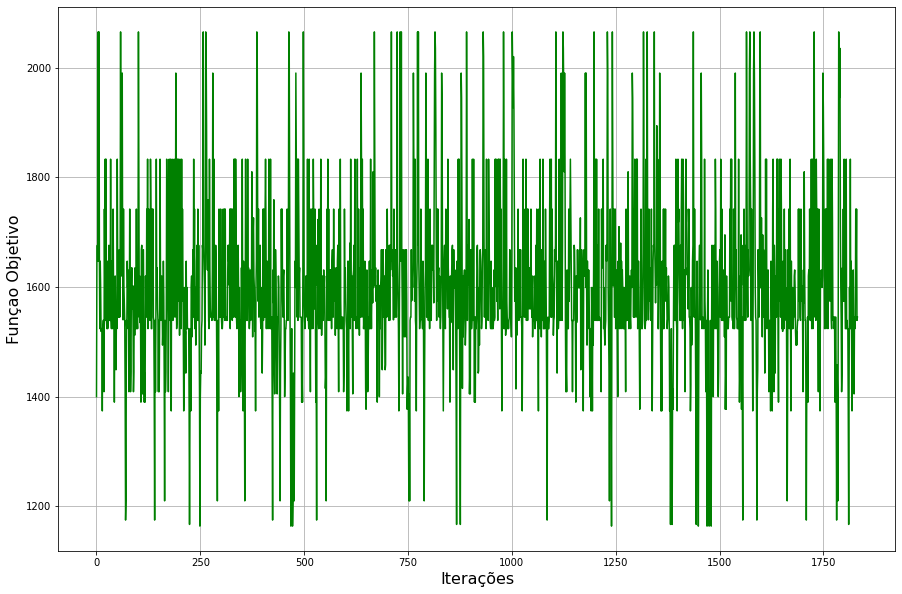

In [62]:
plt.figure(figsize = (15,10))
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue') 
plt.rc('text', usetex='false')
plt.plot(outputs, color = 'green')
plt.ylabel("Funçao Objetivo", fontsize = 16)
plt.xlabel("Iterações", fontsize = 16)
plt.grid()
plt.savefig('Simulated_Annealing.jpg', format='jpg', dpi=300)

In [63]:
dados_b_sa = list() ## dados antes simulated annealing
dados_a_sa = list() ## dados depois simulated annealing
for jobs in S_0:
    if (jobs[7] <= 0):
        dados_b_sa.append(jobs) # antes 
    else:
        dados_a_sa.append(jobs) # depois 

qtdade_jobs_b_sa = len(dados_b_sa) ## quantidade de jobs antes do due date
job_sorteado = random.randint(0,qtdade_jobs_b_sa-1) ## sorteado um job dentre os jobs antes do due date

adicionar_em_a = dados_b_sa[job_sorteado] 
## agora preciso calcular o start_time atual (folga no inicio) e calcular o tempo de processamento
folga_inicio_2 = dados_b_sa[0][6] + dados_b_sa[job_sorteado][1]

lista_cadidata_a = []
for jobs in dados_a_sa:
    if (jobs[1]) <= folga_inicio_2:
        lista_cadidata_a.append(jobs)
    else:
        pass

lista_candidata_sorted = sorted(lista_cadidata_a,key=lambda x: x[8], reverse = True) 
adicionar_em_b_2 = list()
dados_a_copy = dados_a_sa.copy()
sum_pi = 0

for jobs in lista_candidata_sorted:
    sum_pi += jobs[1]
    if sum_pi <= folga_inicio_2:
        adicionar_em_b_2.append(jobs)
    else:
        break

In [64]:
adicionar_em_b_2

[[9, 20, 5, 1, 4.0, 20.0, 114, 31, 31]]

In [65]:
folga_inicio_2

25